## Requirements for this notebook.
to run this notebook you need to install the following packages:
- requests
- aiohttp

### Asyncronous programming
Asyncronous programming is a way of writing code that allows you to run multiple tasks at the same time. This is useful when you have a task that takes a long time to complete, and you want to do other things while you wait for it to finish. Foe example, if you are downloading a file from the internet, you can do other things while you wait for the download to finish, like request another file from the internet. Modern web brousers use asyncronous programming to download multiple elements at the same time, so that the page loads faster. (by default they download 6 elements at the same time)

Python has full support for asyncronous programming. In this notebook we will use the `requests` library to make HTTP requests, and the `aiohttp` library to make asyncronous HTTP requests.

The trick about asyncronous programming is that you have to write your code in a special way. You have to use the `async` and `await` keywords. The `async` keyword is used to define a function that is asyncronous. The `await` keyword is used to wait for an asyncronous function to finish.

An asyncronous function is a function that returns a `coroutine` object. A `coroutine` object is a special object that represents a task that is running (or will start running) in the background, in an `event loop`. 
Asyncronous programming might sound complicated, but it is actually very simple, as long you follow a few rules.
 - You define your asyncronous functions with the `async` keyword.
 - You can only use the `await` keyword inside an asyncronous function.
 - You need to create your tasks before hand.
 - You need to execute your tasks in an `event loop`.

Thankfully recent versions of python have made asyncronous programming very easy compared to older versions.

> Note: A more in depth explanation of asyncronous programming with example can be found in the [trio turotial](https://trio.readthedocs.io/en/stable/tutorial.html).

Here is an example of an asyncronous function:



In [35]:
import asyncio
import time
tasks = set()

async def wait(task_id:str,sleep_time:int):
    print('%s going to sleep!' % task_id)
    start_time = time.time()
    await asyncio.sleep(sleep_time)
    print('%s woke up after %.4f seconds' % (task_id,time.time() - start_time))
    
start_time = time.time()
# add tasks to the set
for task_id,sleep_time in (('task1',3), ('task2',2), ('task3',1)):
    tasks.add(asyncio.ensure_future(wait(task_id,sleep_time)))

# collect results as they come back
for result in asyncio.as_completed(tasks):
    await result

print('all done in %.4f seconds' % (time.time() - start_time) )

task1 going to sleep!
task2 going to sleep!
task3 going to sleep!
task3 woke up after 1.0020 seconds
task2 woke up after 2.0013 seconds
task1 woke up after 3.0018 seconds
all done in 3.0023 seconds


In [5]:
import asyncio
import time
URL_BASE = "https://glasgow-cctv.ubdc.ac.uk/api/"

In [6]:
import aiohttp

session = aiohttp.ClientSession()
result = session.get("https://glasgow-cctv.ubdc.ac.uk/api/")
response = await result
cameras = await response.json()

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x0000021319ADD240>


In [1]:
import aiohttp
import pandas as pd

session = aiohttp.ClientSession()
first_page = session.get("https://glasgow-cctv.ubdc.ac.uk/api/records/")
response = await first_page
record_set = await response.json()
await session.close()
df = pd.DataFrame.from_records(record_set["results"], index="id")

In [2]:
df = pd.DataFrame(columns=df.columns)

In [6]:
import time
import asyncio
import aiohttp
URL_BASE = "https://glasgow-cctv.ubdc.ac.uk/api/"
start_time = time.time()
tasks = set()
sem = asyncio.Semaphore(50)
import pandas as pd
from itertools import product
cameras = [54, 40, 68]


async def get_records(session, page: int = 1, camera_id: int = None):
    async with sem:
        async with session.get(URL_BASE + "records/", params={"page": page}) as resp:
            data = await resp.json()
            return data

first_page = await get_records(session, 1, 54)
first_page_data = await first_page.json()

async with aiohttp.ClientSession() as session:
    for page, camera_id in product(range(1, 100), cameras):
        tasks.add(asyncio.ensure_future(get_records(session, page, camera_id)))
    for result in asyncio.as_completed(tasks):
        data = await result
        df = pd.concat([df, pd.DataFrame.from_records(data["results"], index="id")])
print(time.time() - start_time)

6.80492377281189


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4455 entries, 1010299 to 1011753
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   camera       4455 non-null   object
 1   timestamp    4455 non-null   object
 2   cars         4455 non-null   object
 3   persons      4455 non-null   object
 4   bicycles     4455 non-null   object
 5   trucks       4455 non-null   object
 6   motorcycles  4455 non-null   object
 7   buses        4455 non-null   object
 8   camera_ok    0 non-null      object
dtypes: object(9)
memory usage: 348.0+ KB


In [106]:
df.describe()

,camera,cars,persons,bicycles,trucks,motorcycles,buses
count,1485.0,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000,1485.000000
mean,3.0,2.327273,6.807407,0.052525,0.071380,0.020202,0.277441
std,0.0,1.848534,5.480234,0.248856,0.275252,0.140738,0.607508
min,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.0,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,3.0,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000
75%,3.0,3.000000,11.000000,0.000000,0.000000,0.000000,0.000000
max,3.0,11.000000,25.000000,2.000000,2.000000,1.000000,4.000000


In [64]:
start_time = time.time()
import requests

with requests.Session() as session:
    for page in range(2, 15):
        response = session.get(URL_BASE + "records/", params={"page": page})
        response.json()
print(time.time() - start_time)

1.960942029953003


In [80]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [74]:
import seaborn as sns
import matplotlib as plt

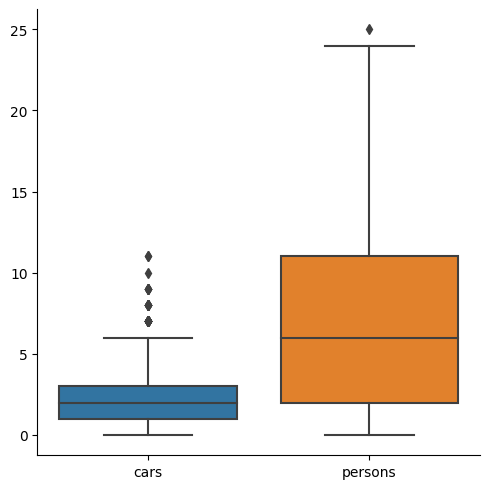

In [91]:
# fig, ax = plt.subplots(figsize=(11, 6))
sns.catplot(
    data=df.drop(
        columns=["camera_ok", "buses", "bicycles", "trucks", "camera", "motorcycles"]
    ),
    kind="box",
)

<AxesSubplot: xlabel='timestamp', ylabel='trucks'>

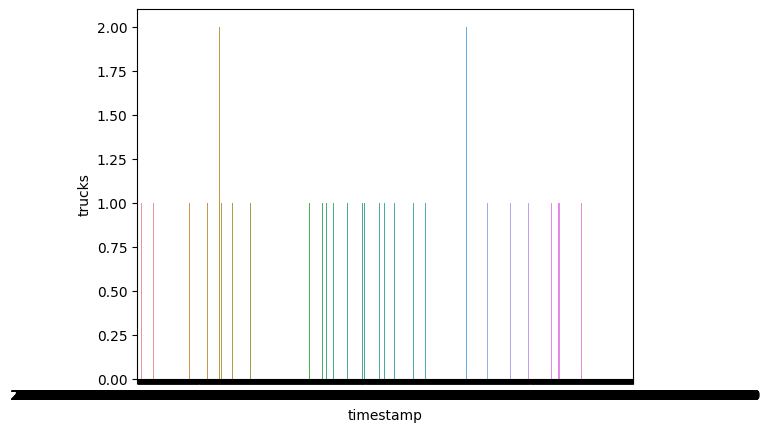

In [105]:
sns.barplot(
    data=df.drop(columns=["camera_ok", "cars", "persons", "camera", "bicycles"]),
    x="timestamp",
    y="trucks",
)